# Grafo: Unidades Nutricionais por rede de Fast Food 

O objetivo foi criar um grafo que representasse o nível de nutrientes presente em cada lanche das redes selecionadas (Starbucks, Mc Donalds e Burguer King).

O gráfico que aparece ao final desse notebook contém todos os dados disponíveis no banco, portanto, está visualmente poluido e, assim, não cumpre os objetivos. Porém, as próximas etapas consistem em criar filtros para resolver esse problema. 

In [1]:
import pandas as pd
import networkx as nx

#import plotly.offline as py
#import plotly.graph_objects as go
import matplotlib.pyplot as plt

Como fizemos a leitura e limpeza de dados no notebook "Dados_MYSQL", aqui só precisamos importa-los:

In [20]:
df = pd.read_csv("fastfood.csv", index_col="name")


Queremos criar nodes que representem cada nutriente, de forma que o tamanho deles seja determinado pela sua quantidade contida em todos os lanches. Para tornar isso possível, somamos essas quantidades e normalizamos os dados.

In [21]:
soma_list,nutri = [],[]

for nutriente in df.columns[0:len(df.columns)-2]: #para cada nutriente no dataframe (-2 para excluir "categoria" e "rede")
    soma_list.append(df[nutriente].sum()) #soma os valores totais 
    nutri.append(nutriente) #guardamos o nome do nutriente

soma_list = pd.Series(soma_list)
  
soma_norm = (soma_list - soma_list.mean())/ soma_list.std() #normalização dos dados totais
soma_min = abs(soma_norm.min())

soma_norm = round((soma_norm + soma_min + 1)*700) #deixa todos os valores > 0 
    
soma_nutri = dict(zip(nutri,soma_norm)) #criamos um dicionário com o nutriente e sua soma total normalizada

Agora precisamos simplismente criar o grafo, os nós e as arestas.

In [22]:
fastfood = nx.Graph()  #criar o grafo

#criar os nós para cada unidade nutricional  
for nutrientes in df.columns[0:len(df.columns)-2]:
    fastfood.add_node(nutrientes,color="grey",size=soma_nutri[nutrientes])
    # soma_nutri possui os dados normalizads criados anteriormente
    
# criar os nós para cada lanche    
for lanche in df.index:
     fastfood.add_node(lanche, color= df.loc[lanche,"rede"],size=700,categoria=df.loc[lanche,"categoria"]) #criando os nós de cada lanche 
     # o atributo categoria será usado futuramente para filtrar o grafo
        
        
#criar uma aresta ligando os lanches e os nós
for lanche in df.index:
    for nutriente in df.columns[0:len(df.columns)-2]:
        local = (df.copy()).dropna() # não faz sentido criar uma aresta se não temos o valor
        if local.loc[lanche,nutriente] > 0: #tbm não faz se o valor for zero
            fastfood.add_edge(lanche, nutriente, weight = local.loc[lanche,nutriente])
            # atribuimos o peso como o peso do nutriente, que foi normalizado
            

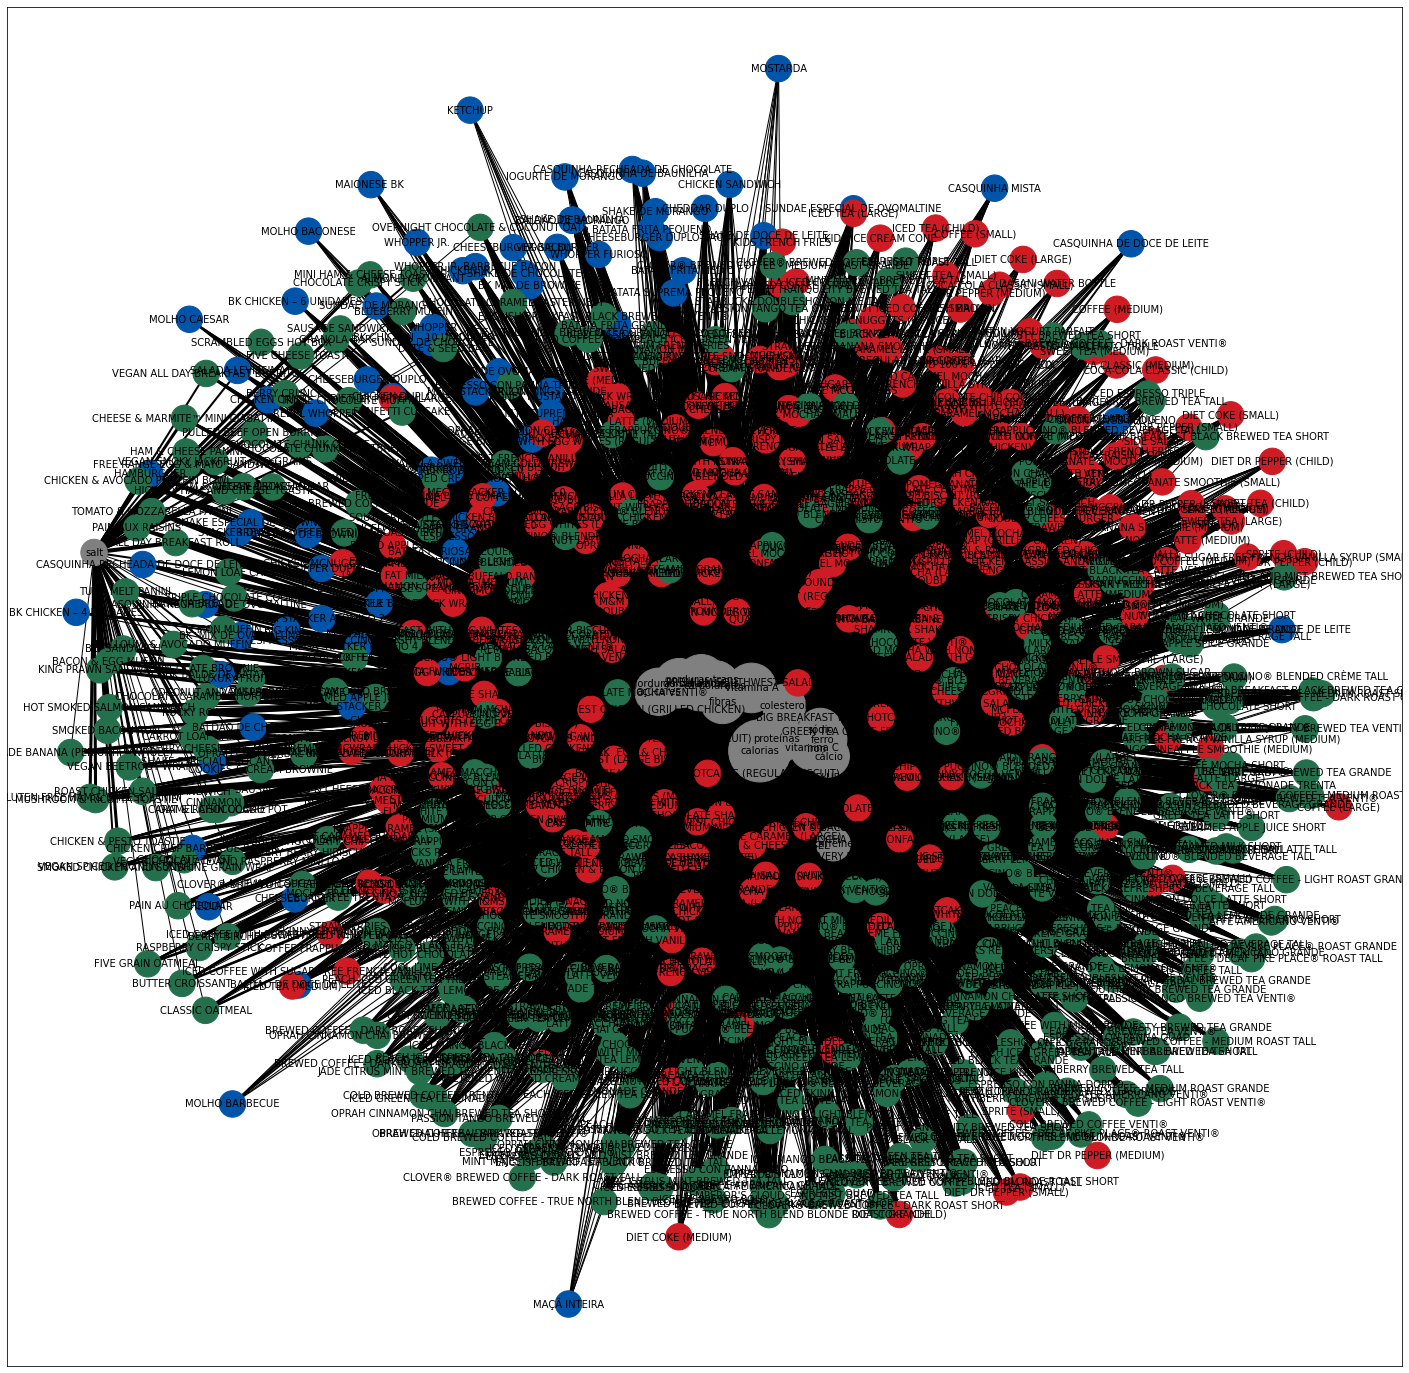

In [23]:
#plotar o grafo        
fig, ax = plt.subplots(figsize=(25,25))
nx.draw_networkx(fastfood,  
                  arrows=True,
                  with_labels=True,
                  ax=ax,
                  node_size=[nx.get_node_attributes(fastfood,'size')[g] for g in fastfood.nodes()], 
                  node_shape='o',
                  node_color=[nx.get_node_attributes(fastfood,'color')[g] for g in fastfood.nodes()],
                  alpha=1.0,
                  width=list(nx.get_edge_attributes(fastfood,'weight').values()),
                  style='solid',
                  font_size=10,
                  font_color='black',
                  font_weight='normal',
                  font_family='sans-serif')

In [6]:
#import json
#nodes = nx.cytoscape_data(fastfood)['elements']['nodes']
#edges = nx.cytoscape_data(fastfood)['elements']['edges']

#with open('nodes.txt', 'w') as outfile:
   # json.dump(nodes, outfile)
#with open('edges.txt', 'w') as outfile:
   # json.dump(edges, outfile)    

In [7]:
import json
grafo = nx.cytoscape_data(fastfood)['elements']

with open('grafo.txt', 'w') as outfile:
    json.dump(grafo, outfile)    

In [12]:
from pyvis.network import Network

In [18]:
ft = Network()
ft.from_nx(fastfood)
ft.show("network_map.html") #fica mt estranho (